<!--NOTEBOOK_HEADER-->
*This notebook contains course material from [CBE32338](https://jckantor.github.io/CBE32338)
by Jeffrey Kantor (jeff at nd.edu); the content is available [on Github](https://github.com/jckantor/CBE2338.git).
The text is released under the [CC-BY-NC-ND-4.0 license](https://creativecommons.org/licenses/by-nc-nd/4.0/legalcode),
and code is released under the [MIT license](https://opensource.org/licenses/MIT).*

# PI control

Dans les travaux précédents on a pu identifier la fonction de transfert liant l'echauffement $Q1$ à la température $T1$ comme :
- un 1er ordre avec retard pur
$$ G_1(s) = \frac{\Delta T_1(s)}{Q_1(s)}= \frac{0.46e^{-21s}}{151s + 1} $$
- un second ordre
$$ G_1(s) = \frac{\Delta T_1(s)}{Q_1(s)}= \frac{0.46}{(21s + 1)(151s + 1)} $$

$\Delta T_1$ exprimant ici l'écart relatif entre la température du capteur et la température ambiante (autour de 20°C).

On peut trouver [ici](http://www8.umoncton.ca/umcm-cormier_gabriel/Asservissements/GELE5313_Notes7.pdf) un cours sur les asservissements introduisant les différentes formes de correcteurs. L'approche Ziegler-Nichols de réglage de ces correcteurs est notemment rappelé :
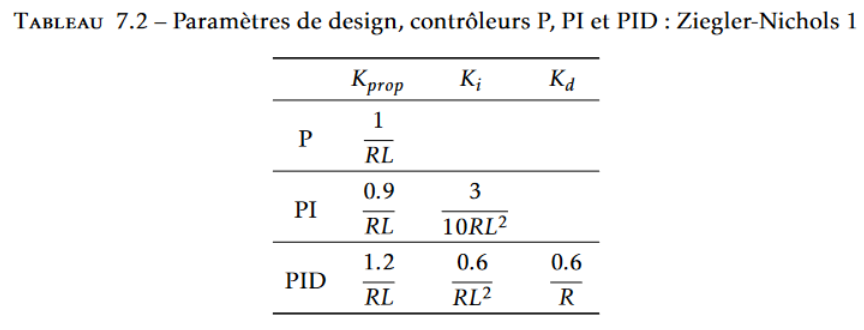

pour un système de fonction de transfert de la forme $ G(s) = \frac{Ke^{-Ls}}{\tau s + 1} $ avec $R=K/\tau$.



> Réaliser le controle en température avec correcteur proportionnel de type PI. Analyser les performances par simulation de manières temporelles et fréquentielles (Bode en boucle ouverte et boucle fermée). Comparer ces résultats à des essais réels. 




# PI Controller define with Zielgler-Nichols method

On reprend l'approche Ziegler-Nichols sur un controleur PI defini avec la fonction de transfert suivante:
$G_c(s)=k_p(1+\frac{1}{\tau_i s})=k_p+\frac{k_i}{s}$

Definit les gain suivant pour le controleur:  
$k_p = \frac{0.9}{RL}$  
$k_i = \frac{3}{10 R L^2}$

soit aussi :  
$\tau_i = \frac{k_p}{k_i}=3L$

Une autre approche définit les coefficients suivants :
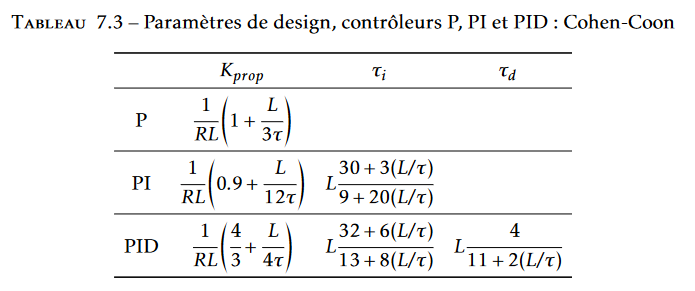

Autre méthode 
https://apmonitor.com/pdc/index.php/Main/ProportionalIntegralDerivative

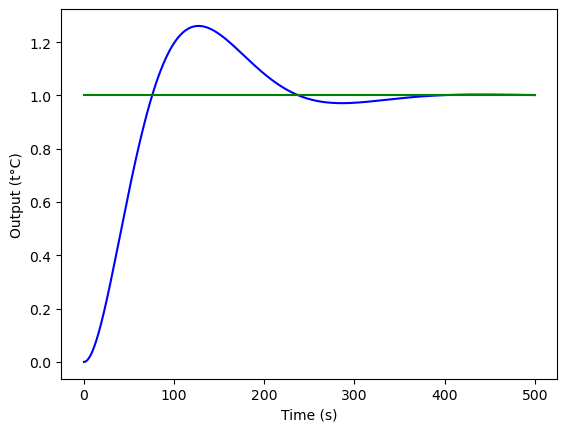

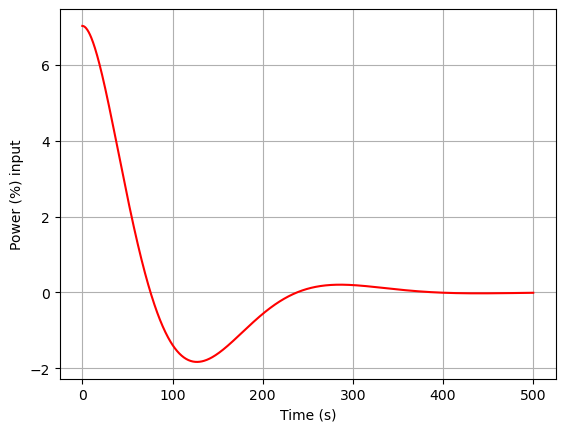

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import control.matlab as control

# Ziegler Nichols input parameter
tau = 151 # [s] time constant of the 1st order
L= 21 # [s] delay
K = 0.46 # [°/%] static gain

R=K/tau

# controller coefficient with Ziegler Nichols approach
Kp = 1.20*K*L/tau*0 + 0.9/R/L*0.5

Taui = 3*L

# controller constants with cohen-coon approach 
#Kp = 1/R/L*(1+L/3/tau)*0.8
#Taui = L * (30+3*L/tau)/(9+20*L/tau)*3


# system transfer function, based on second order model
G1 = 0.46*control.tf([1],[21,1])*control.tf([1],[151,1])

# controller and global model transfer functions
Gc = control.tf([Kp, Kp/Taui],[1, 0])
T = Gc*G1
H = T/(1+T)

# Step response of the closed loop
t = np.linspace(0,500,1000)
y,t = control.step(H,t)
Q,t = control.step(Kp/(1+T),t)
plt.plot(t,y, 'b', t,np.ones(1000),'g-')
plt.xlabel('Time (s)')
plt.ylabel('Output (t°C)')
plt.show()

plt.plot(t,Q, 'r')
plt.xlabel('Time (s)')
plt.ylabel('Power (%) input')
plt.grid()
plt.show()

In [2]:
%whos

Variable   Type                Data/Info
----------------------------------------
G1         TransferFunction    \n        0.46\n---------<...>-\n3171 s^2 + 172 s + 1\n
Gc         TransferFunction    \n7.034 s + 0.1117\n----------------\n       s\n
H          TransferFunction    \n               1.026e+0<...>+ 13.07 s^2 + 0.05136 s\n
K          float               0.46
Kp         float               7.03416149068323
L          int                 21
Q          ndarray             1000: 1000 elems, type `float64`, 8000 bytes
R          float               0.0030463576158940397
T          TransferFunction    \n  3.236 s + 0.05136\n--<...>n3171 s^3 + 172 s^2 + s\n
Taui       int                 63
control    module              <module 'control.matlab' <...>ol\\matlab\\__init__.py'>
np         module              <module 'numpy' from 'C:\<...>ges\\numpy\\__init__.py'>
plt        module              <module 'matplotlib.pyplo<...>\\matplotlib\\pyplot.py'>
t          ndarray             1000

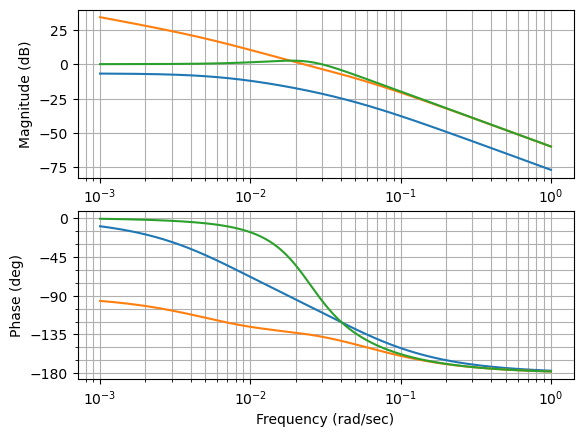

In [3]:
# Bode diagram of open loops
mag,phase,omega = control.bode(G1,T,H)

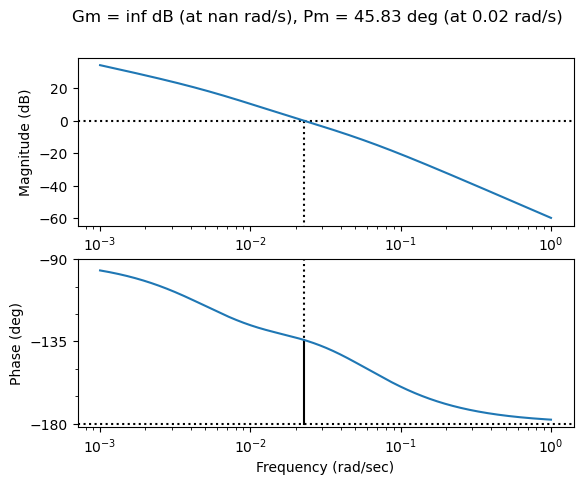

In [4]:
# Print phase and gain margins
mag,phase,omega = control.bode(T, margins = True)

# Implementation of a simple PI controller

La fonction de transfert d'un controleur Proportionnel - Integral PI est la suivante :
$G_c(s)=k_p(1+\frac{1}{\tau_i s})=k_p+\frac{k_i}{s}$

Given a process variable $PV$ (measure) and setpoint $SP$ (order), proportional-integral-derivative control determines the value of a manipulated variable MV by the equation

\begin{align}
MV & = \bar{MV} + k_p\left(SP - PV\right) + k_i \int_0^t (SP-PV) dt
\end{align}

where $k_p$ and $k_i=k_p/\tau_i$ are the proportional and integral coefficients, respectively. The value $\bar{MV}$ is a nominal or initial value of the manipulated variable.

The actual implementation of PI control is normally done by computing how much the $MV$ should change at each time step. Defining the error at time $k$ as

\begin{align}
e_k & = SP_k - PV_k
\end{align}

then consecutive values of $MV$ are given by 

\begin{align}
MV_{k-1} & = \bar{MV} + k_p e_{k-1} + k_i \sum_{j=0}^{k-1} e_{j} \Delta T \\
MV_{k} & = \bar{MV} + k_p e_{k} + k_i \sum_{j=0}^{k} e_{j} \Delta T
\end{align}

Taking differences gives a practical formula for updating the value of $MV$ in response to measurements

\begin{align}
MV_{k} & = MV_{k-1} + k_p(e_{k} - e_{k-1}) + k_i \Delta T e_{k}
\end{align}

The following code defines a Python object that implements this algorithm.

In [5]:
class PI:
    def __init__(self, kp=1, ki=0, MV=0):
        self.kp = kp
        self.ki = ki
        self.e = 0
        self.eint = 0
        self.MV = MV
        self.pt = 0
        
    def update(self, SP, PV, t):
      
        e = SP - PV
        dt= t-self.pt
        self.pt=t
        self.eint += e*dt
        self.e = e
        
    
        self.MV = self.kp * self.e + self.ki * self.eint 
        
        # anti-Windup
        self.MVsat = max(0, min(100, self.MV))
        # si saturation on arrete d'integrer l'action integrale
        if self.MVsat != self.MV :
            print(".", end='')
            self.eint -= e*dt
        
        return self.MV
    
    


The following cell provides an initial implementation of PI control for heater T1.  

In [6]:
from tclab import TCLab, clock

#from tclab import TCLab

lab = TCLab()
lab.LED(100)


# from tclab import TCLab

print("Temperature 1: %0.2f °C"%(lab.T1))
print("Temperature 2: %0.2f °C"%(lab.T2))


TCLab version 1.0.0
Arduino Leonardo connected on port COM6 at 115200 baud.
TCLab Firmware 2.0.1 Arduino Leonardo/Micro.
Temperature 1: 24.09 °C
Temperature 2: 23.32 °C


In [7]:
import matplotlib.pyplot as plt
import numpy as np

time = []
Q1 = []
Kperror = []
T1 = []

Torder = 40

tfinal = 1000
tstep = 1

pid = PI()
pid.kp = Kp
pid.ki = Kp/Taui

for t in clock(tfinal, tstep):
    print('/', end='')
    Q = pid.update(Torder, lab.T1, t)
    Qsat = max(0,min(100, Q))
    lab.Q1(Qsat)
    time = time + [t]
    T1 = T1 + [lab.T1]
    Q1 = Q1 + [Q]
    
    
print("\nTurn Heater Q1 Off")
lab.Q1(0)
lab.close()

/././././././././././././././././././././////////////////////////////////////////////////////////////////////////////////////////.//.//./././././././///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

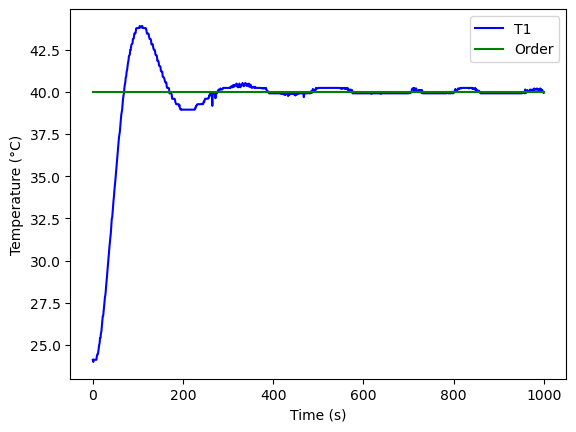

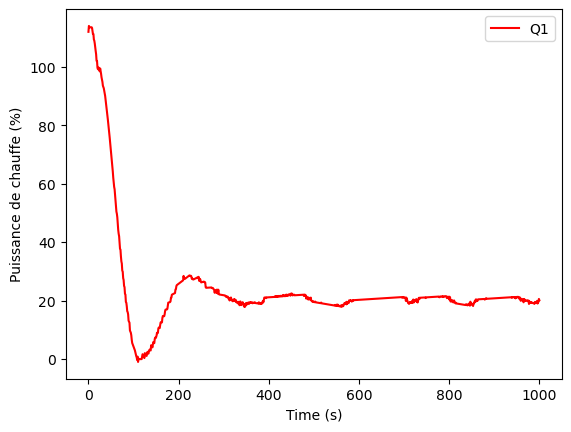

In [8]:
plt.plot(time, T1,'b-', label='T1')
plt.plot(time, np.ones(len(time))*Torder,'g-', label='Order')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()

plt.plot(time, Q1,'r-', label='Q1')
plt.xlabel('Time (s)')
plt.ylabel('Puissance de chauffe (%)')
plt.legend()
plt.show()

................................

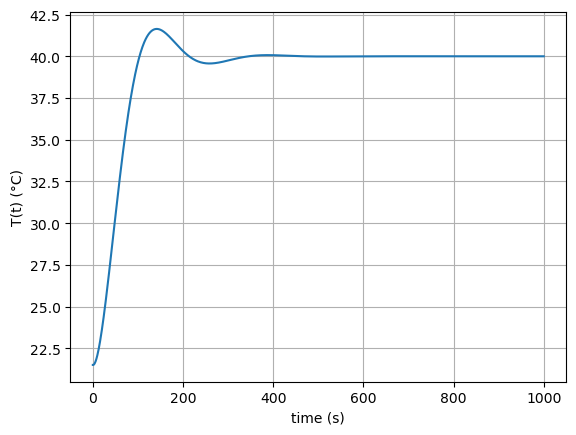

In [10]:
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import fmin_slsqp
import matplotlib.pyplot as plt


Torder=40

pid = PI()
pid.kp = Kp
pid.ki = Kp/Taui

# https://perso.crans.org/besson/publis/notebooks/Runge-Kutta_methods_for_ODE_integration_in_Python.html
    
def rungekutta1(f, y0, t):
    n = len(t)
    y = np.zeros((n, len(y0)))
    y[0] = y0
    for i in range(n - 1):
        y[i+1] = y[i] + (t[i+1] - t[i]) * np.array(f(y[i], t[i]))
    return y

# function that returns dy/dt
def model(y,t):
    T, Tp = y
    # Controller
    Q = pid.update(Torder, T, t)
    Qsat = max(0,min(100, Q))
    # System
    Tpp = (0.46*Qsat-(T-21.5)-151*Tp)/(21*151)
    dydt = [Tp, Tpp]
    return dydt 

# initial condition
T0 = [21.5,0]

# time points
t = np.linspace(0,1000,1001)

# solve ODE
#y = odeint(model,T0,t)
y = rungekutta1(model,T0,t)

# plot results
plt.plot(t,y[:,0])
plt.xlabel('time (s)')
plt.ylabel('T(t) (°C)')
plt.grid()
plt.show()
